# Human Emotion Recognition

### Personal Project

Nina Cardenas

## 0. Initialization and setup

In [44]:
!pip install plotly
!pip install matplotlib
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install -U scikit-learn
!pip install scipy

  Using cached tensorflow_metal-0.7.1-cp39-cp39-macosx_12_0_arm64.whl (1.4 MB)


In [60]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as ks
import tensorflow as tf
import sklearn.model_selection as model_selection
import keras
import scipy
from keras.preprocessing.image import ImageDataGenerator

## 1. Data Collection and Analysis

In [61]:
raw_df = pd.read_csv("fer2013.csv")
labels = ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]
labels_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

In [62]:
raw_df.shape

(35887, 3)

In [63]:
raw_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### 1.1 Analyzing class distribution

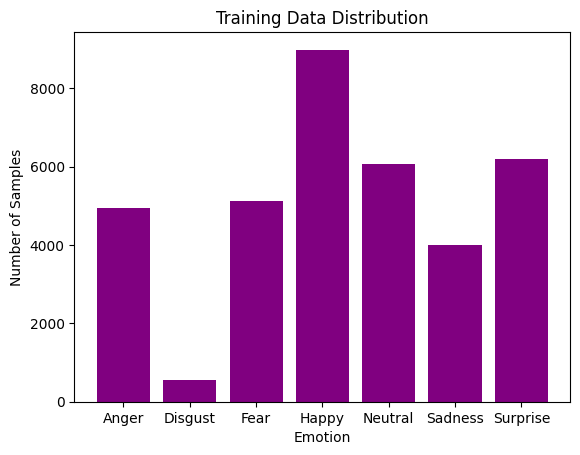

In [64]:
plt.title("Training Data Distribution")
plt.bar(labels, [list(raw_df['emotion']).count(i) for i in np.unique(raw_df['emotion'])], color="purple")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")

plt.show()

### 1.2 Class imbalance

In [76]:
occ = np.bincount(raw_df['emotion'])
total = np.sum(occ)
disgust = np.amin(occ)
happy = np.amax(occ)
print('Total classes: {}\nTotal samples: {}\nDisgust: {} ({:.2f}% of total)\nHappy: {} ({:.2f}% of total)\n'.format(len(occ),
    total, disgust, 100 * disgust / total,happy,100*happy/total))

Total classes: 7
Total samples: 35887
Disgust: 547 (1.52% of total)
Happy: 8989 (25.05% of total)



## 2. Preprocessing

In [80]:
# shuffle dataset
df = raw_df.sample(frac=1)#,random_state=1)
df

,emotion,pixels,Usage
35719,3,174 172 173 167 106 110 101 73 66 100 121 120 ...,PrivateTest
24782,2,147 143 136 130 135 150 150 138 120 130 133 13...,Training
16509,6,92 91 92 82 37 33 43 41 33 27 24 27 31 36 43 5...,Training
17657,3,79 106 86 72 91 96 97 111 97 89 94 102 122 119...,Training
13235,3,224 224 223 225 223 222 221 221 217 121 24 19 ...,Training
...,...,...,...
15552,0,30 49 111 126 132 144 154 154 164 173 178 182 ...,Training
10968,2,71 65 60 45 44 43 43 43 61 86 95 109 115 115 1...,Training
28463,0,14 10 17 51 31 29 31 41 47 58 63 54 39 31 29 2...,Training
6950,6,89 92 95 99 104 107 111 115 122 118 48 53 43 3...,Training


In [81]:
# one hot enconding
onehot_labels = ks.utils.to_categorical(df[['emotion']], num_classes=7)

In [9]:
#train = df[df['Usage'] == 'Training]

In [82]:
data = np.float32(df['pixels'].astype('str').str.split(" ").tolist())
data.shape

(35887, 2304)

In [83]:
np.amax(data) #maximum value in unscaled data

255.0

In [84]:
np.amin(data) # minimum value in unscaled data

0.0

In [85]:
data = data / 255.0
data

array([[0.68235296, 0.6745098 , 0.6784314 , ..., 0.11764706, 0.11764706,
        0.11764706],
       [0.5764706 , 0.56078434, 0.53333336, ..., 0.5411765 , 0.56078434,
        0.6117647 ],
       [0.36078432, 0.35686275, 0.36078432, ..., 0.25490198, 0.28627452,
        0.23529412],
       ...,
       [0.05490196, 0.03921569, 0.06666667, ..., 0.8627451 , 0.95686275,
        0.88235295],
       [0.34901962, 0.36078432, 0.37254903, ..., 0.69803923, 0.6901961 ,
        0.6862745 ],
       [0.5294118 , 0.46666667, 0.37254903, ..., 0.12941177, 0.21568628,
        0.5176471 ]], dtype=float32)

In [86]:
from math import sqrt
sqrt(2304)

48.0

In [87]:
data = data.reshape((35887,48,48,1))

In [88]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, onehot_labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [89]:
datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             zoom_range = 0.2)
valgen = ImageDataGenerator(width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            horizontal_flip = True,
                            zoom_range = 0.2) 

In [175]:
datagen.fit(X_train)
valgen.fit(X_val)

In [176]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

## 3. ConvNet Model

In [183]:
# defining cnn model layers
model = keras.Sequential([
    # layer 1 (conv2d)
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', kernel_initializer="random_normal", input_shape=(48, 48, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    # layer 2 (conv2d)
    keras.layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # layer 3 (conv2d)
    keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # layer 4 (conv2d)
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(filters=256,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # layer 4 (conv2d)
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
     # flattening
    keras.layers.Flatten(),
    
    # layer 5 (dense)
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # layer 6 (dense)
    keras.layers.Dense(7, activation='softmax')
])

In [184]:
# printing model summary
model.summary()

# compiling model using adam optimizer and categorical ce loss function
# only metric analyzed is accuracy
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,decay=1e-6), #'adam'
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_98 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_102 (Conv2D)         (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_84 (Bat  (None, 12, 12, 64)     

In [186]:
model.fit(train_generator,
          batch_size=256,
          epochs=20,
          verbose=1,
          validation_data=val_generator)

Epoch 1/20


2023-03-01 14:49:47.126898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


455/455 [==============================] - ETA: 0s - loss: 4.2700 - accuracy: 0.2278

2023-03-01 14:50:19.291213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


455/455 [==============================] - 35s 73ms/step - loss: 4.2700 - accuracy: 0.2278 - val_loss: 2.4752 - val_accuracy: 0.1381
Epoch 2/20
455/455 [==============================] - 31s 67ms/step - loss: 1.9622 - accuracy: 0.2541 - val_loss: 1.9492 - val_accuracy: 0.2461
Epoch 3/20
455/455 [==============================] - 31s 68ms/step - loss: 1.8501 - accuracy: 0.3181 - val_loss: 1.7863 - val_accuracy: 0.3365
Epoch 4/20
455/455 [==============================] - 30s 66ms/step - loss: 1.7117 - accuracy: 0.3750 - val_loss: 1.7008 - val_accuracy: 0.3762
Epoch 5/20
455/455 [==============================] - 30s 67ms/step - loss: 1.6233 - accuracy: 0.4109 - val_loss: 1.5613 - val_accuracy: 0.4192
Epoch 6/20
455/455 [==============================] - 30s 66ms/step - loss: 1.5051 - accuracy: 0.4478 - val_loss: 1.6277 - val_accuracy: 0.3991
Epoch 7/20
455/455 [==============================] - 30s 66ms/step - loss: 1.4306 - accuracy: 0.4722 - val_loss: 1.4350 - val_accuracy: 0.4517
Epo

In [187]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [188]:
model.history.history['val_accuracy']

[0.13808049261569977,
 0.24613003432750702,
 0.33653250336647034,
 0.37616100907325745,
 0.4191950559616089,
 0.39907121658325195,
 0.4517028033733368,
 0.4863777160644531,
 0.44520124793052673,
 0.5247678160667419,
 0.5263158082962036,
 0.5139318704605103,
 0.5396285057067871,
 0.553250789642334,
 0.5421052575111389,
 0.5591331124305725,
 0.5482972264289856,
 0.5160990953445435,
 0.5640866756439209,
 0.5513932108879089]

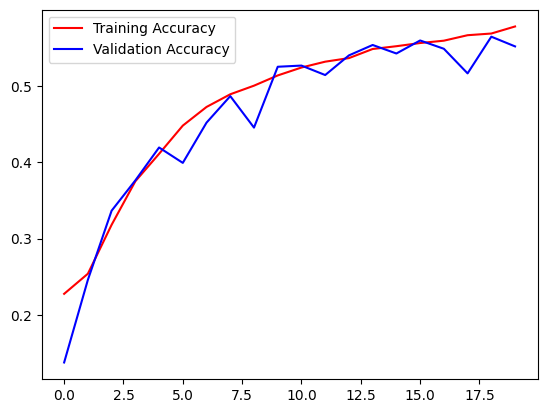

In [189]:
plt.plot(model.history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(model.history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

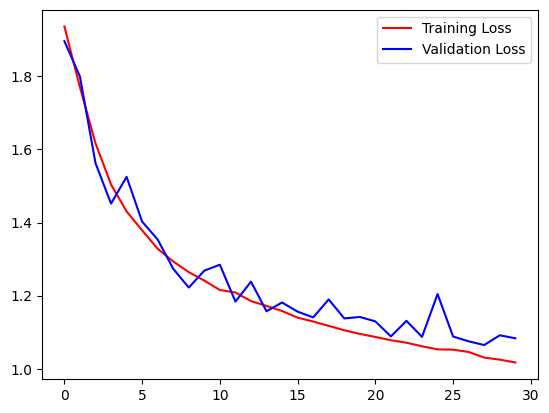

In [190]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

In [191]:
test_loss, test_acc = model.evaluate(X_test, y_test,batch_size=128)

print('Test accuracy:', test_acc)
print('Test loss: ', test_loss)

29/29 [==============================] - 2s 47ms/step - loss: 1.1711 - accuracy: 0.5698
Test accuracy: 0.569796621799469
Test loss:  1.1710658073425293


In [174]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model and model weights to disk.")

Saved model and model weights to disk.
